In [1]:
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage.io, skimage.color, skimage.transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from sklearn.model_selection import train_test_split

path = r"C:\Users\owais akmad khan\OneDrive\Desktop\project\archive_Copy\\"
files = np.array(pd.read_csv(r"C:\Users\owais akmad khan\OneDrive\Desktop\project\archive_Copy\files.csv"))

selected_indices = np.random.choice(len(files), int(0.56 * len(files)), replace=False)
selected_files = files[selected_indices, 0]

files_train, files_valid, cls_train, cls_valid = train_test_split(
    selected_files, files[selected_indices, 1], test_size=0.2, random_state=40
)

print(files_train.shape, files_valid.shape)
cls_train = to_categorical(cls_train, 205, dtype='int')
cls_valid = to_categorical(cls_valid, 205, dtype='int')


(106684,) (26672,)


In [5]:
def batch_generator(for_train, batch_size):
    while True:
        if for_train is True:
            idx = np.random.randint(0, files_train.shape[0], batch_size)
        else:
            idx = np.random.randint(0, files_valid.shape[0], batch_size)

            
        gray = np.zeros((batch_size, 256, 256, 1))
        colo = np.zeros((batch_size, 256, 256, 2))
        cls = np.zeros((batch_size, 205))
        
        for i in range(batch_size):
            if for_train is True:
                temp = skimage.io.imread(path + files_train[idx[i]])
                cls[i,:] = cls_train[idx[i]]
            else:
                temp = skimage.io.imread(path + files_valid[idx[i]])
                cls[i,:] = cls_valid[idx[i]]
                
            temp = skimage.color.rgb2lab(temp)
            temp = skimage.transform.resize(temp, (256, 256))
            gray[i,:,:,0] = temp[:,:,0]
            colo[i] = temp[:,:,1:]
            
        gray = gray/100
        colo = (colo+128)/255
        yield gray, [cls, colo]


In [6]:
gray_image = Input(shape=(256, 256, 1))

In [7]:
conv = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(gray_image))
low_glo = BatchNormalization()(conv(gray_image))

conv = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))



In [8]:
# 3. Regularization (Dropout)
low_mid = Dropout(0.5)(low_mid)

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
glo = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='tanh')(low_glo)
glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(glo)
glo = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='tanh')(glo)
glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(glo)
glo = Flatten()(glo)
glo = Dense(1024, activation='tanh')(glo)
glo_512 = Dense(512, activation='tanh')(glo)
glo = Dense(256, activation='tanh')(glo_512)
print(glo)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")


In [11]:
# Classification
cls = Dense(256, activation='tanh')(glo_512)
cls = Dense(205, activation='softmax')(cls)

In [12]:
mid = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
mid = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='tanh')(mid)
print(mid)  

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv2d_11/Tanh:0', description="created by layer 'conv2d_11'")


In [13]:
print(mid)
print(glo)

fused = Reshape((1, 1, 256))(glo)
fused = Lambda(lambda x: tf.tile(x, (1, 32, 32, 1)))(fused)
fused = concatenate([mid, fused], 3)
fused = Dense(256, activation='tanh')(fused)
print(fused)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv2d_11/Tanh:0', description="created by layer 'conv2d_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='dense_5/Tanh:0', description="created by layer 'dense_5'")


In [14]:
colo = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='tanh')(fused)
colo = UpSampling2D((2, 2))(colo)
colo = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
colo = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
colo = UpSampling2D((2, 2))(colo)
colo = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
output = Conv2D(2, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')(colo)
output = UpSampling2D((2, 2))(output)
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None), name='up_sampling2d_2/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_2'")


In [15]:
conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
low_mid = BatchNormalization()(conv)
low_mid = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
low_mid = BatchNormalization()(low_mid)

conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_glo)
low_glo = BatchNormalization()(conv)
low_glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_glo)
low_glo = BatchNormalization()(low_glo)

In [17]:
model = Model(inputs=gray_image, outputs=[cls, output])
model.compile(optimizer = "adam", loss = ["categorical_crossentropy", "mse"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]',                
                                )                                 'input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 64  256        ['conv2d[1][0]']                 
 rmalization)                   )                                                             

In [18]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss=["categorical_crossentropy", "mse"])

c:\Users\owais akmad khan\.conda\envs\owais\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
batch_size = 8
train_gen = batch_generator(True, batch_size = batch_size)
valid_gen = batch_generator(False, batch_size = batch_size)

In [20]:
callbacks = [
    ModelCheckpoint('update_model.h5', save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [21]:
history = model.fit(
    x=train_gen,
    epochs=6,
    steps_per_epoch=files_train.shape[0] // (batch_size // 2),
    validation_data=valid_gen,
    validation_steps=files_valid.shape[0] // (batch_size // 2),
    callbacks=callbacks
)

Epoch 1/6


26671/26671 [==============================] - 10855s 407ms/step - loss: 5.1071 - dense_4_loss: 5.1040 - up_sampling2d_2_loss: 0.0030 - val_loss: 4.9197 - val_dense_4_loss: 4.9169 - val_up_sampling2d_2_loss: 0.0028
Epoch 2/6
26671/26671 [==============================] - 10933s 410ms/step - loss: 4.6223 - dense_4_loss: 4.6196 - up_sampling2d_2_loss: 0.0027 - val_loss: 4.4713 - val_dense_4_loss: 4.4686 - val_up_sampling2d_2_loss: 0.0027
Epoch 3/6
26671/26671 [==============================] - 17843s 669ms/step - loss: 4.3153 - dense_4_loss: 4.3127 - up_sampling2d_2_loss: 0.0026 - val_loss: 4.2780 - val_dense_4_loss: 4.2754 - val_up_sampling2d_2_loss: 0.0026
Epoch 4/6
26671/26671 [==============================] - 10774s 404ms/step - loss: 4.1371 - dense_4_loss: 4.1345 - up_sampling2d_2_loss: 0.0026 - val_loss: 4.1283 - val_dense_4_loss: 4.1258 - val_up_sampling2d_2_loss: 0.0025
Epoch 5/6
26671/26671 [==============================] - 11771s 441ms/step - loss: 3.9861 - dense_4_loss: 3.98

In [23]:
def colorize(orig, resized):
    predicted = model.predict(resized)[1]
    resized = np.concatenate((resized, predicted), axis=3)

    for pos in range(resized.shape[0]):
        resized[pos,:,:,0] = resized[pos,:,:,0]*100
        resized[pos,:,:,1:] = resized[pos,:,:,1:]*255 - 128
        resized[pos] = skimage.color.lab2rgb(resized[pos])

        temp = skimage.color.rgb2gray(orig[pos])
        skimage.io.imshow(orig[pos])
        plt.show()

        final_image = skimage.transform.resize(resized[pos], orig[pos].shape)
        skimage.io.imshow(final_image)
        plt.show()

1/1 [==============================] - 2s 2s/step


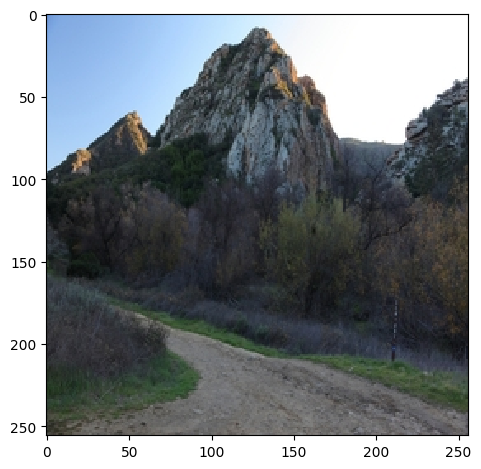

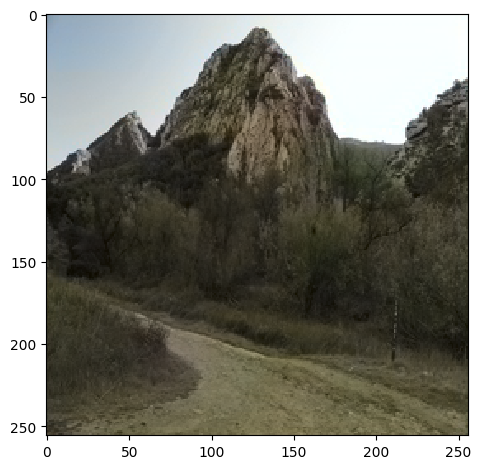

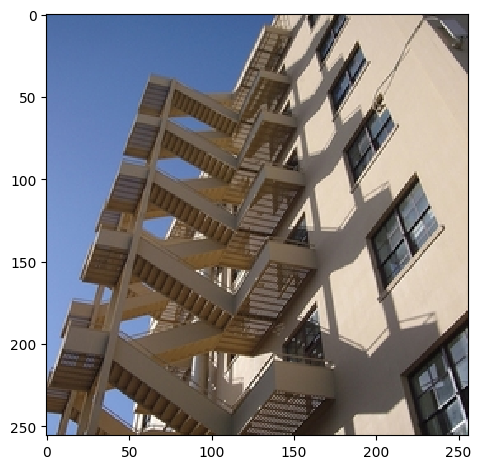

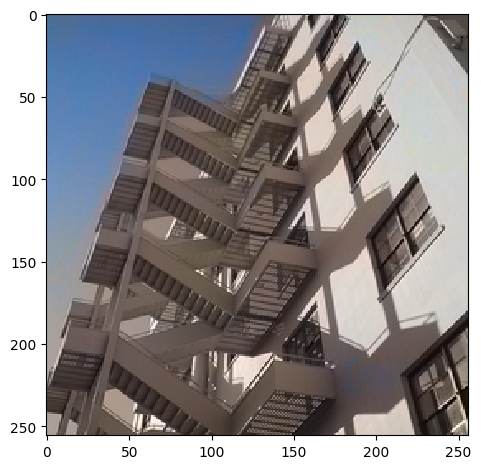

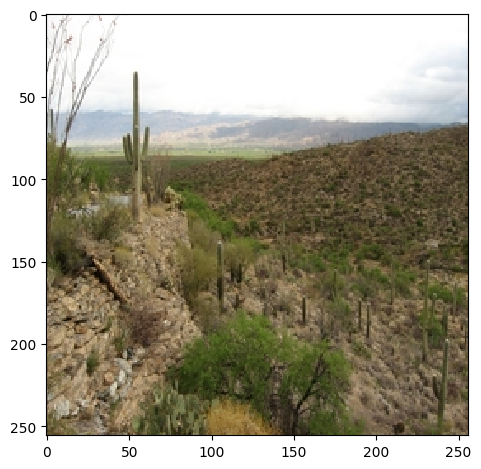

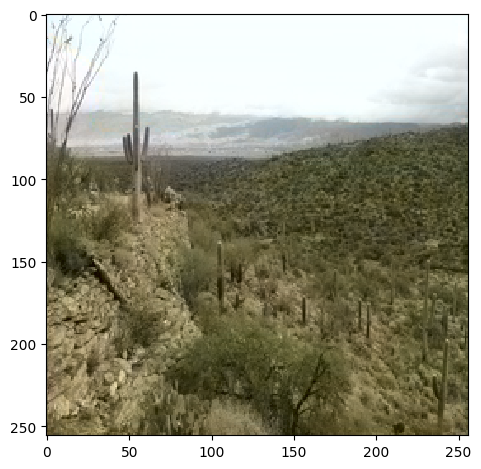

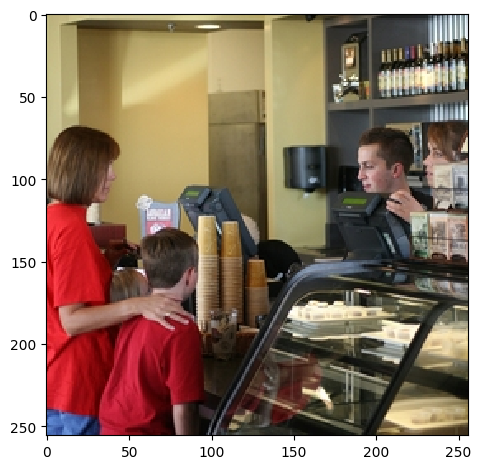

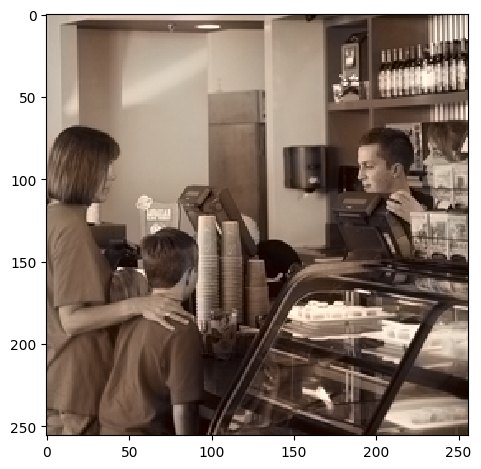

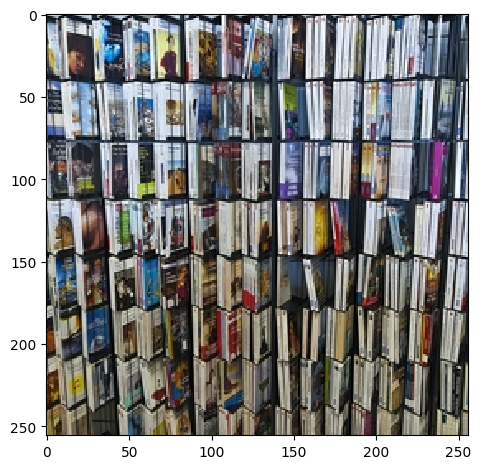

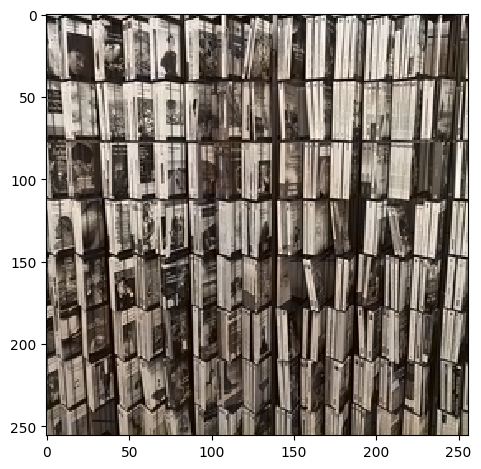

In [24]:
files = files_train
orig = []
num = 5
resized = np.zeros((num, 256, 256, 1))
for pos in range(num):
    orig.append(skimage.io.imread(path + files[pos]))
    temp = skimage.transform.resize(orig[pos], (256, 256))
    if temp.shape == (256, 256, 3):
        temp = skimage.color.rgb2lab(temp)[:,:,0]
        temp = temp/100
    if temp.shape == (256, 256, 1):
        resized[pos] = temp
    else:
        resized[pos,:,:,0] = temp
colorize(orig, resized)

1/1 [==============================] - 0s 173ms/step


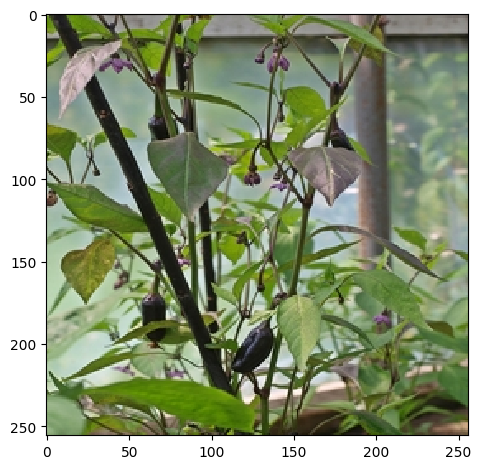

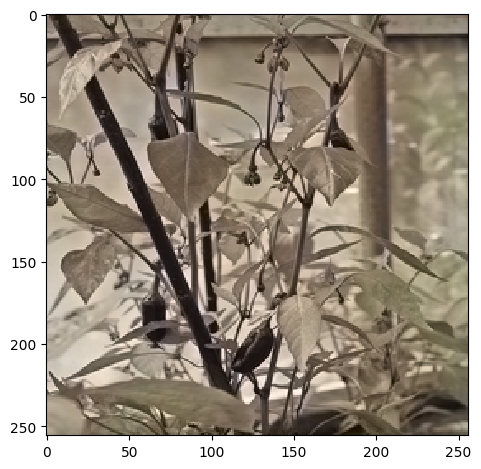

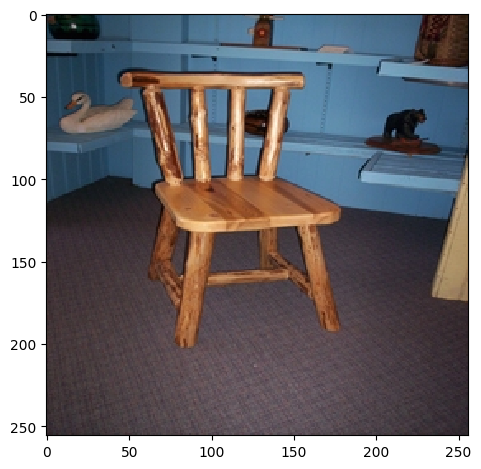

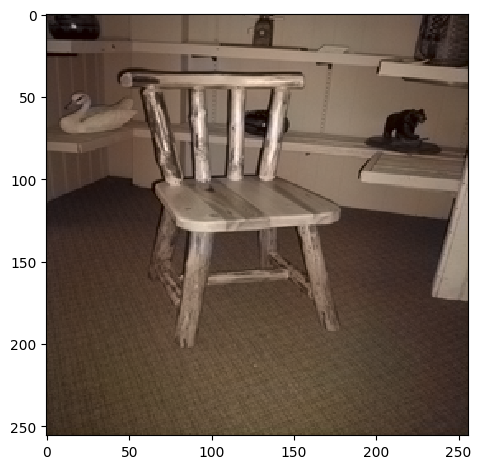

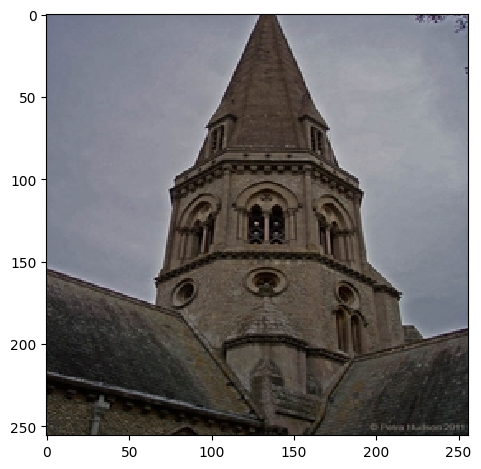

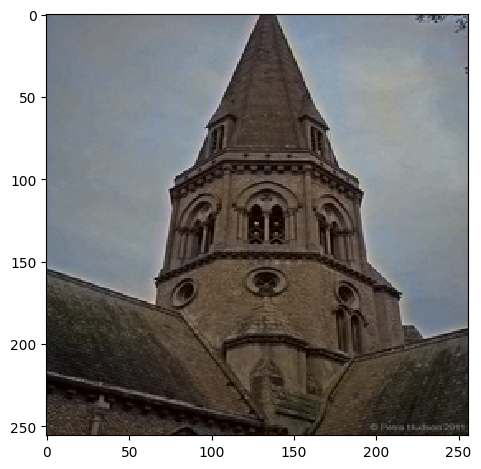

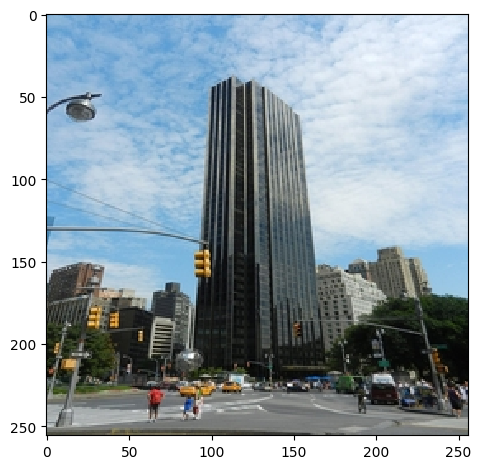

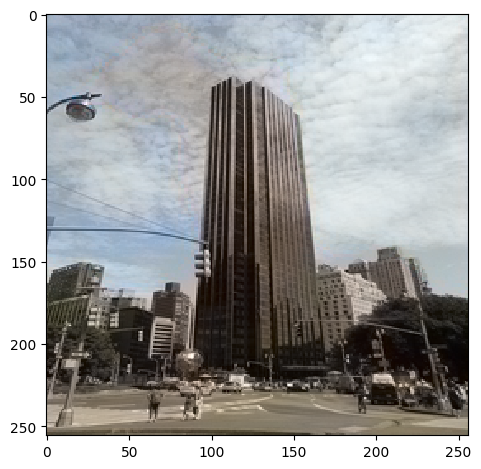

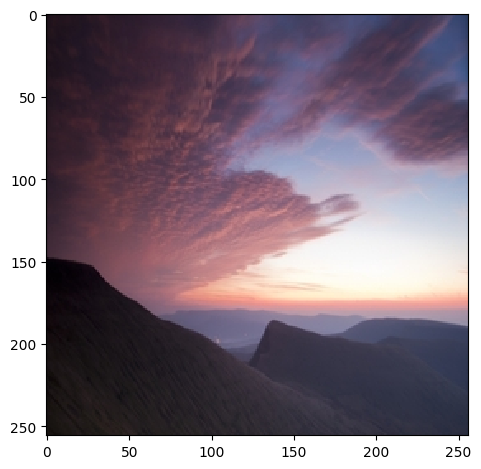

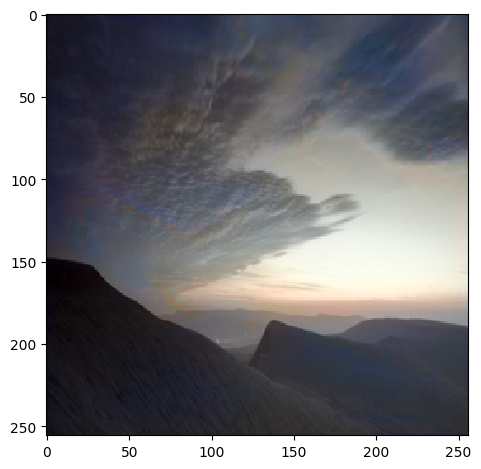

In [25]:
files = files_valid
orig = []
num = 5
resized = np.zeros((num, 256, 256, 1))
for pos in range(num):
    orig.append(skimage.io.imread(path + files[pos]))
    temp = skimage.transform.resize(orig[pos], (256, 256))
    if temp.shape == (256, 256, 3):
        temp = skimage.color.rgb2lab(temp)[:,:,0]
        temp = temp/100
    if temp.shape == (256, 256, 1):
        resized[pos] = temp
    else:
        resized[pos,:,:,0] = temp
colorize(orig, resized)